In [1]:
import cv2 as cv
import numpy as np
import mlflow
import dagshub
import os
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import pickle
from tqdm import tqdm
import seaborn as sns

In [2]:
PATH = pathlib.Path('C:\\Users\\vinar\\Downloads\\FER2013-augmented')
LABELS = os.listdir(PATH)

In [3]:
dagshub.init(repo_owner='IdjiotSandwiches', repo_name='face-emotion-recognition', mlflow=True)

Accessing as IdjiotSandwiches

Initialized MLflow to track repo "IdjiotSandwiches/face-emotion-recognition"

Repository IdjiotSandwiches/face-emotion-recognition initialized!

In [4]:
K_SIZE = (21,21)
SIGMA = 3
THETA_RANGE = np.arange(0, np.pi, np.pi/32)
LAMBD = 10.0
GAMMA = 0.5
PSI = 0
FLOATING_POINT = cv.CV_32F
IMAGE_SIZE = (48,48)
N_COMPONENTS = 0.95
N_COMPONENTS_LOCAL = 16
BLUR = (5,5)

gabor_params = {
    'ksize': K_SIZE,
    'sigma': SIGMA,
    'lambd': LAMBD,
    'gamma': GAMMA,
    'psi': PSI
}

KERNELS = [cv.getGaborKernel(**gabor_params, theta=theta) for theta in THETA_RANGE]

In [5]:
from joblib import Parallel, delayed

def process_image(img_path, label, dir):
    path = f'{dir}/{label}'
    img = cv.imread(f'{path}/{img_path}', 0)
    img = cv.resize(img, IMAGE_SIZE)
    img = cv.GaussianBlur(img, BLUR, 0)
    img = cv.equalizeHist(img)

    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    if len(faces) > 0:
        x, y, w, h = faces[0]
        img = img[y:y+h, x:x+w]
    else:
        h, w = img.shape[:2]
        crop_size = min(h, w)
        x = (w - crop_size) // 2
        y = (h - crop_size) // 2
        img = img[y:y+crop_size, x:x+crop_size]
    
    img = cv.copyMakeBorder(
        img, 
        10, 10, 10, 10,
        cv.BORDER_CONSTANT, 
        value=(0, 0, 0)
    )
    
    img = cv.resize(img, IMAGE_SIZE)
    img = img / 255.0
    img = gabor_filter(img)

    img = img.reshape(img.shape[0], -1)
    pca = PCA(n_components=N_COMPONENTS_LOCAL)
    img = pca.fit_transform(img)

    folder_path = f'C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\new\\{label}'
    os.makedirs(folder_path, exist_ok=True)
    img_path = img_path.split('.')
    np.save(f'{folder_path}/{img_path[0]}.npy', img)


def open_dataset(dir):
    results = Parallel(n_jobs=4)(delayed(process_image)(img_path, label, dir)
                                   for label in LABELS
                                   for img_path in tqdm(os.listdir(f'{dir}/{label}')))

In [37]:
images, labels = open_dataset(PATH)

100%|██████████| 12000/12000 [01:20<00:00, 148.39it/s]


In [5]:
images = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\48x48\\images.npy')
labels = np.load('C:\\Users\\vinar\\Downloads\\gabor-filtered-imgs\\FER2013\\48x48\\labels.npy')

In [6]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
CALIB_SIZE = 0.8
TRAIN_SIZE = 10000

split_params = {
    'test_size': TEST_SIZE,
    'random_state': RANDOM_STATE
}

calib_params = {
  'test_size': CALIB_SIZE,
  'random_state': RANDOM_STATE
}

# X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
# X_train, _, y_train, _ = train_test_split(
#     images, labels, train_size=TRAIN_SIZE, stratify=labels, random_state=42
# )

X_train, X_test, y_train, y_test = train_test_split(images, labels, **split_params, stratify=labels)
X_calib, X_test, y_calib, y_test = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metri

Accuracy: 0.18928571428571428
Precision: 0.15597428781693645
Recall: 0.18928571428571428
F1 Score: 0.1675581055613238
AUC Score: 0.522448648904006
              precision    recall  f1-score   support

       angry       0.18      0.21      0.19       840
        fear       0.00      0.00      0.00       840
       happy       0.22      0.27      0.24       840
     neutral       0.16      0.10      0.13       840
         sad       0.19      0.25      0.22       840
    surprise       0.18      0.30      0.23       840

    accuracy                           0.19      5040
   macro avg       0.16      0.19      0.17      5040
weighted avg       0.16      0.19      0.17      5040



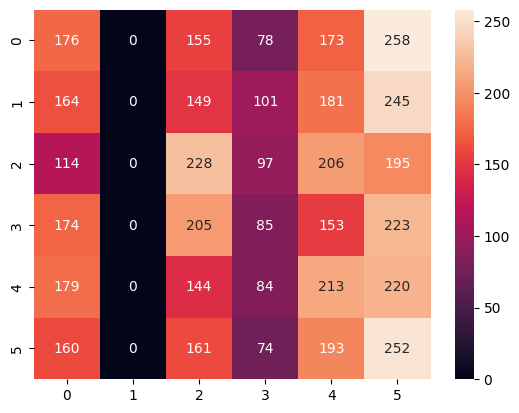

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/b139eee3b27549058adcb2f220c3beb5
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19
Accuracy: 0.19424603174603175
Precision: 0.20573927057700506
Recall: 0.19424603174603175
F1 Score: 0.17893033705885078
AUC Score: 0.518546768707483
              precision    recall  f1-score   support

       angry       0.22      0.18      0.20       840
        fear       0.18      0.22      0.20       840
       happy       0.23      0.23      0.23       840
     neutral       0.17      0.35      0.23       840
         sad       0.24      0.02      0.04       840
    surprise       0.19      0.16      0.18       840

    accuracy                           0.19      5040
   macro avg       0.21      0.19      0.18      5040
weighted avg       0.21      0.19      0.18      5040



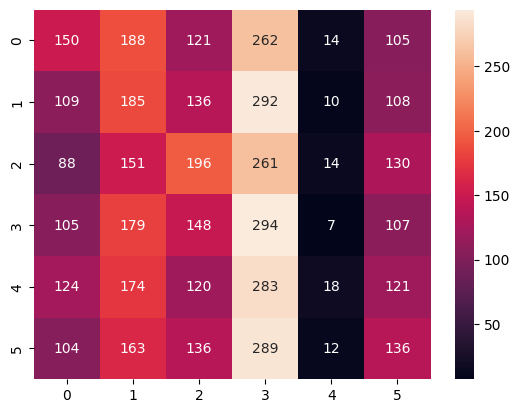

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/9687b5f40fcd4906ae2918bdc2449949
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19
Accuracy: 0.17142857142857143
Precision: 0.15880571863084916
Recall: 0.1714285714285714
F1 Score: 0.13848937405631348
AUC Score: 0.5091485260770975
              precision    recall  f1-score   support

       angry       0.19      0.01      0.01       840
        fear       0.18      0.36      0.24       840
       happy       0.21      0.19      0.20       840
     neutral       0.07      0.00      0.01       840
         sad       0.15      0.26      0.19       840
    surprise       0.16      0.21      0.18       840

    accuracy                           0.17      5040
   macro avg       0.16      0.17      0.14      5040
weighted avg       0.16      0.17      0.14      5040



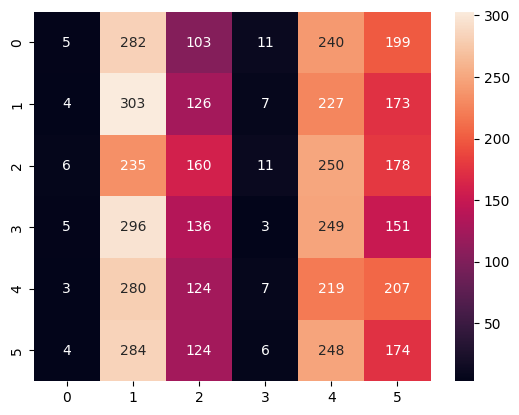

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/f9d93d6c74b341c9ac3933aed3dbef73
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19


d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metri

Accuracy: 0.19523809523809524
Precision: 0.1621143803468967
Recall: 0.1952380952380952
F1 Score: 0.17306559333873342
AUC Score: 0.5265576814058958
              precision    recall  f1-score   support

       angry       0.19      0.26      0.22       840
        fear       0.00      0.00      0.00       840
       happy       0.21      0.38      0.27       840
     neutral       0.19      0.16      0.18       840
         sad       0.20      0.17      0.18       840
    surprise       0.18      0.20      0.19       840

    accuracy                           0.20      5040
   macro avg       0.16      0.20      0.17      5040
weighted avg       0.16      0.20      0.17      5040



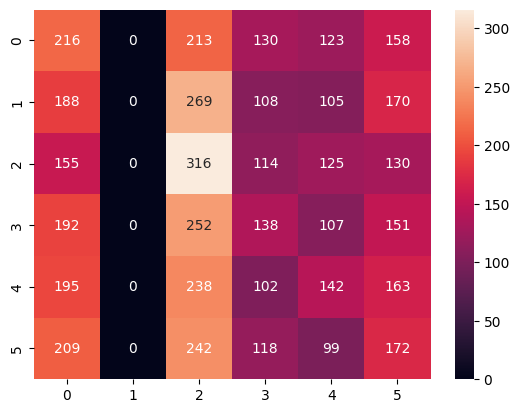

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/d16254a978a84e4e8edb196cbb32976d
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19


d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metri

Accuracy: 0.19027777777777777
Precision: 0.1593539905286329
Recall: 0.19027777777777777
F1 Score: 0.15472623812242656
AUC Score: 0.5264927248677248
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       840
        fear       0.20      0.22      0.21       840
       happy       0.23      0.23      0.23       840
     neutral       0.17      0.02      0.03       840
         sad       0.19      0.25      0.21       840
    surprise       0.17      0.43      0.25       840

    accuracy                           0.19      5040
   macro avg       0.16      0.19      0.15      5040
weighted avg       0.16      0.19      0.15      5040



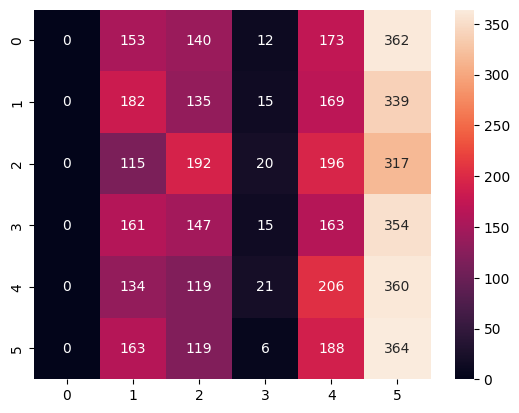

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/bc38cec5e49a4e8bb4adbebcee76c1f8
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19
Accuracy: 0.18035714285714285
Precision: 0.16697846276699088
Recall: 0.18035714285714285
F1 Score: 0.13292560824045266
AUC Score: 0.5198086262282691
              precision    recall  f1-score   support

       angry       0.13      0.00      0.01       840
        fear       0.11      0.02      0.04       840
       happy       0.25      0.12      0.16       840
     neutral       0.15      0.07      0.10       840
         sad       0.19      0.26      0.22       840
    surprise       0.18      0.60      0.27       840

    accuracy                           0.18      5040
   macro avg       0.17      0.18      0.13      5040
weighted avg       0.17      0.18      0.13      5040



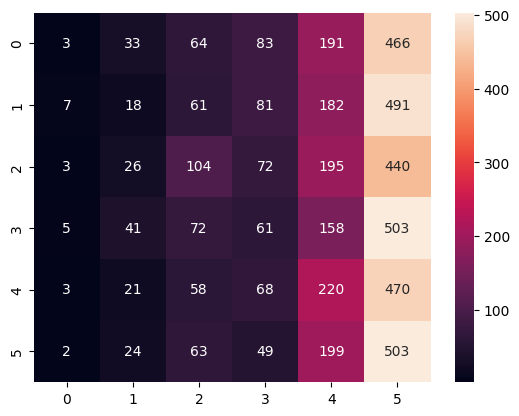

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/50351d35ca0a457db94ad74f33e806ab
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19
Accuracy: 0.18968253968253967
Precision: 0.19158478967533096
Recall: 0.18968253968253967
F1 Score: 0.16953815051535295
AUC Score: 0.5261045918367347
              precision    recall  f1-score   support

       angry       0.19      0.22      0.20       840
        fear       0.19      0.06      0.09       840
       happy       0.21      0.29      0.24       840
     neutral       0.20      0.03      0.05       840
         sad       0.18      0.24      0.21       840
    surprise       0.18      0.30      0.23       840

    accuracy                           0.19      5040
   macro avg       0.19      0.19      0.17      5040
weighted avg       0.19      0.19      0.17      5040



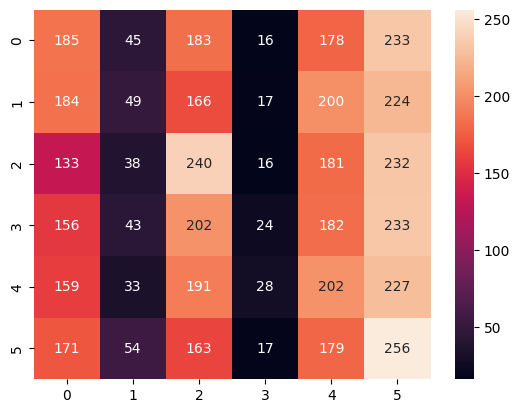

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/67c04e97c75a4ae4a361f4c16349fc1c
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19


d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PythonProject\env\Lib\site-packages\sklearn\metri

Accuracy: 0.18115079365079365
Precision: 0.15126646003173175
Recall: 0.18115079365079367
F1 Score: 0.16274204206729675
AUC Score: 0.5257536375661377
              precision    recall  f1-score   support

       angry       0.17      0.26      0.21       840
        fear       0.00      0.00      0.00       840
       happy       0.21      0.22      0.21       840
     neutral       0.17      0.13      0.15       840
         sad       0.19      0.26      0.22       840
    surprise       0.17      0.22      0.19       840

    accuracy                           0.18      5040
   macro avg       0.15      0.18      0.16      5040
weighted avg       0.15      0.18      0.16      5040



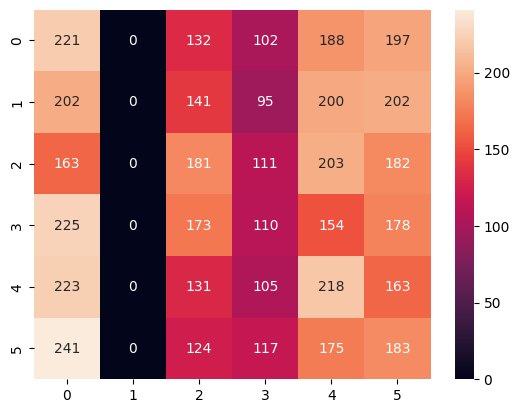

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/b8286a2594954a0d875b93302d4e9d2e
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19
Accuracy: 0.18968253968253967
Precision: 0.1841159392521843
Recall: 0.18968253968253967
F1 Score: 0.17113219658268378
AUC Score: 0.5287303004535148
              precision    recall  f1-score   support

       angry       0.17      0.07      0.10       840
        fear       0.18      0.33      0.23       840
       happy       0.21      0.35      0.26       840
     neutral       0.16      0.07      0.10       840
         sad       0.20      0.23      0.21       840
    surprise       0.19      0.09      0.12       840

    accuracy                           0.19      5040
   macro avg       0.18      0.19      0.17      5040
weighted avg       0.18      0.19      0.17      5040



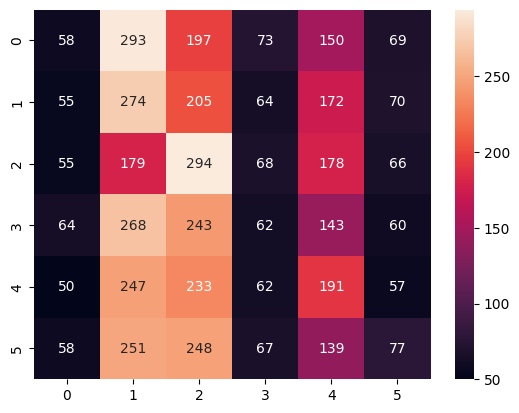

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/4d7487d252104a6cb708a1300b4ad45a
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19
Accuracy: 0.17956349206349206
Precision: 0.1597537080770767
Recall: 0.17956349206349206
F1 Score: 0.12866042542154657
AUC Score: 0.5272324263038548
              precision    recall  f1-score   support

       angry       0.17      0.35      0.23       840
        fear       0.12      0.00      0.01       840
       happy       0.19      0.45      0.27       840
     neutral       0.12      0.02      0.04       840
         sad       0.19      0.23      0.21       840
    surprise       0.17      0.01      0.02       840

    accuracy                           0.18      5040
   macro avg       0.16      0.18      0.13      5040
weighted avg       0.16      0.18      0.13      5040



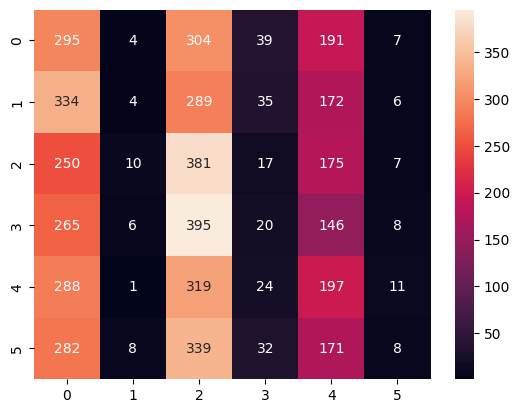

🏃 View run SVM LinearSVC at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19/runs/05a219f66495483e87248145150e322f
🧪 View experiment at: https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow/#/experiments/19


In [7]:
C = 0.1
TEST_SIZE = 0.7
RANDOM_STATE = 42
N_SPLITS = 10
SHUFFLE = True

model_params = {
  'C': C,
}

calib_params = {
  'test_size': TEST_SIZE,
  'random_state': RANDOM_STATE
}

kfold_params = {
    'n_splits': N_SPLITS,
    'shuffle': SHUFFLE
}

skf = StratifiedKFold(**kfold_params)
i = 0

for train_idx, test_idx in skf.split(images, labels):
  X_train, X_test = images[train_idx], images[test_idx]
  y_train, y_test = labels[train_idx], labels[test_idx]

  X_calib, X_test, y_calib, y_test = train_test_split(X_test, y_test, **calib_params, stratify=y_test)

  model = LinearSVC(**model_params)
  model.fit(X_train, y_train)

  calib_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
  calib_model.fit(X_calib, y_calib)

  predict = calib_model.predict(X_test)
  predict_proba = calib_model.predict_proba(X_test)

  metrics = {
    'accuracy': accuracy_score(y_test, predict),
    'precision': precision_score(y_test, predict, average='macro'),
    'recall': recall_score(y_test, predict, average='macro'),
    'f1': f1_score(y_test, predict, average='macro'),
    'auc_score': roc_auc_score(y_test, predict_proba, multi_class='ovr', average='macro')
  }

  print(f"Accuracy: {metrics['accuracy']}\nPrecision: {metrics['precision']}\nRecall: {metrics['recall']}\nF1 Score: {metrics['f1']}\nAUC Score: {metrics['auc_score']}")
  report = classification_report(y_test, predict)
  print(report)

  cm = confusion_matrix(y_test, predict)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.savefig('confusion_matrix.png')
  plt.show()

  mlflow.set_experiment("KNN_Model FER2013 224x224")
  mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

  mlflow.set_experiment("SVM_Model FER2013 augmented")
  mlflow.set_tracking_uri("https://dagshub.com/IdjiotSandwiches/face-emotion-recognition.mlflow")

  with mlflow.start_run(run_name=f'SVM LinearSVC'):
      mlflow.log_params(gabor_params)
      mlflow.log_params(model_params)
      mlflow.log_param('floating_point', FLOATING_POINT)
      mlflow.log_param('image_size', IMAGE_SIZE)
      mlflow.log_param('PCA_n_components', N_COMPONENTS)
      mlflow.log_param('gaussian_blur', BLUR)
      mlflow.log_metrics(metrics)
      mlflow.log_artifact('confusion_matrix.png')
      mlflow.sklearn.log_model(
          sk_model=model,
          artifact_path='SVM Model',
          input_example=X_train[:1]
      )
  i = i + 1

In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10, 100],
}

grid_search = GridSearchCV(
    estimator=LinearSVC(dual=False, verbose=True),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LibLinear][CV] END ................................C=0.1, max_iter=100; total time=   0.1s
[LibLinear][CV] END ................................C=0.1, max_iter=100; total time=   0.2s
[LibLinear][CV] END ................................C=0.1, max_iter=100; total time=   0.2s
[LibLinear][CV] END ...............................C=0.1, max_iter=1000; total time=   0.2s
[LibLinear][CV] END ...............................C=0.1, max_iter=1000; total time=   0.2s
[LibLinear][CV] END ...............................C=0.1, max_iter=1000; total time=   0.2s
[LibLinear][CV] END ..............................C=0.1, max_iter=10000; total time=   0.2s
[LibLinear][CV] END ..............................C=0.1, max_iter=10000; total time=   0.2s
[LibLinear][CV] END ..............................C=0.1, max_iter=10000; total time=   0.2s
[LibLinear][CV] END ..................................C=1, max_iter=100; total time=   0.1s
[LibLinear][CV] END

GridSearchCV(cv=3, estimator=LinearSVC(dual=False, verbose=True),
             param_grid={'C': [0.1, 1, 5, 10, 100],
                         'max_iter': [100, 1000, 10000]},
             scoring='accuracy', verbose=2)